In [12]:
#Importujemo neophodne biblioteke

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin

In [13]:
#importujemo dataset

cardio = pd.read_csv("cardio_train.csv", sep=";", index_col = "id")
cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [14]:
#Opis dataseta - Podaci u kolonama su:
#age - in days, gender: 1 - women, 2 - men, height - cm, weight - kg,
#ap_hi - Systolic blood pressure, ap_lo - Diastolic blood pressure,
#cholesterol - 1: normal, 2: above normal, 3: well above normal,
#gluc - 1: normal, 2: above normal, 3: well above normal
#smoke - whether patient smokes or not
#alco - Binary feature, active - Binary feature
#cardio - Target variable

In [15]:
#Podešavamo broj decimala u DF
pd.set_option("precision", 2)

#dimenzije 
cardio.shape

(70000, 12)

In [16]:
#provera da li ima nedostajućih podataka

cardio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [17]:
#provera podataka po kolonama

cardio["gender"].values

array([2, 1, 1, ..., 2, 1, 1], dtype=int64)

In [18]:
cardio["height"].values

array([168, 156, 165, ..., 183, 163, 170], dtype=int64)

In [19]:
cardio.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.0,70000.0
mean,19468.87,1.35,164.36,74.21,128.82,96.63,1.37,1.23,0.09,0.05,0.8,0.5
std,2467.25,0.48,8.21,14.40,154.01,188.47,0.68,0.57,0.28,0.23,0.4,0.5
min,10798.00,1.00,55.00,10.00,-150.00,-70.00,1.00,1.00,0.00,0.00,0.0,0.0
25%,17664.00,1.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
50%,19703.00,1.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
75%,21327.00,2.00,170.00,82.00,140.00,90.00,2.00,1.00,0.00,0.00,1.0,1.0
max,23713.00,2.00,250.00,200.00,16020.00,11000.00,3.00,3.00,1.00,1.00,1.0,1.0


In [20]:
#Postoji nekoliko problema u Datasetu koje treba korigovati:
# Kolona age - starost je data u danima, potrebno je konvertovati u godine 
# Kolona ap_hi - postoje vrednosti gornjeg krvnog pritiska koje su nemoguće
# Kolona ap_lo - postoje vrednosti gornjeg krvnog pritiska koje su nemoguće

In [21]:
#Pretvaramo podatke kolonu "age" iz broja dana starosti u godine starosti
starost = cardio["age"]/365
starost = np.floor(starost)
starost = starost.astype(float)
cardio["age"] = starost
cardio.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,51.0,1,165,64.0,130,70,3,1,0,0,0,1


In [22]:
#Kolone ap_hi i ap_lo uređujemo koristeći Inter Quartile Range metod koji uklanja 
# ekstremne vrednosti - Outliers. Prvo definišemo kontinuirane podatke na koje 
# primenjujemo metod. Ostale kolone su definisane

continuous = ["age", "height", "weight", "ap_hi", "ap_lo"]
Q1 = cardio.quantile(0.25)
Q3 = cardio.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

age            10.0
gender          1.0
height         11.0
weight         17.0
ap_hi          20.0
ap_lo          10.0
cholesterol     1.0
gluc            0.0
smoke           0.0
alco            0.0
active          0.0
cardio          1.0
dtype: float64


In [23]:
#Uklanjamo Outliers-e odnosno ekstremne podatke

clean = cardio[~((cardio[continuous] < (Q1 - 1.5 * IQR)) | (cardio[continuous] > (Q3 + 1.5 * IQR))).any(axis = 1)]
clean.shape

(62502, 12)

In [24]:
#Proveravamo Dataset da li ima ekstremnih vrednosti

clean.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.00,62502.0,62502.00
mean,52.91,1.35,164.41,73.18,126.42,81.70,1.36,1.22,0.09,0.05,0.8,0.49
std,6.74,0.48,7.53,12.27,14.29,7.67,0.68,0.57,0.28,0.22,0.4,0.50
min,39.00,1.00,143.00,40.00,90.00,65.00,1.00,1.00,0.00,0.00,0.0,0.00
25%,48.00,1.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.00
50%,54.00,1.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.00
75%,58.00,2.00,170.00,81.00,140.00,90.00,1.00,1.00,0.00,0.00,1.0,1.00
max,64.00,2.00,186.00,107.00,170.00,105.00,3.00,3.00,1.00,1.00,1.0,1.00


In [25]:
clean.to_csv("cardio_clean.csv")

## Simple linear regresion

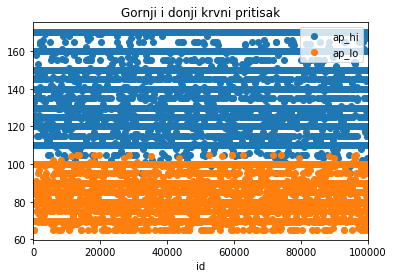

In [26]:
#Primena mašinskog učenja korišćenjem linearne regresije. Prvo ćemo koristiti 
#linearnu regresiju samo sa dva parametra - Simple Linear Regresion, a potom 
# Multiple Linear Regresion

#Simple Linear Regresion
clean.plot( y = ["ap_hi", "ap_lo"], style = "o" )
plt.title("Gornji i donji krvni pritisak")
plt.show()

In [27]:
#Želimo da na osnovu poznavanja donjeg krvnog pritiska pogodimo gornji krvni pritisak, pa 
#podešavamo ap_lo da nam bude x atribut, a ap_hi da nam bude lebel

#Prilikom primene fit  metoda javlja nam se value error koji traži da se ispravi 
# dodavanjem array.reshape(-1, 1)
X = clean["ap_lo"].values.reshape(-1, 1)
y = clean["ap_hi"].values.reshape(-1, 1)

In [28]:
#Delimo dataset na trening i test skup

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [29]:
regresor = LinearRegression()
regresor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [30]:
#U jednačini linearne regresije y = A*x + B gde je regresor intecept_ = B

print(regresor.intercept_)

[18.88434357]


In [31]:
#U jednačini linearne regresije y = A*x + B gde je regresor coef_ (slope) = A

print(regresor.coef_)

[[1.31610406]]


In [32]:
#primenjujemo predviđanje gornjeg pritiska na osnovu donjeg

y_pred = regresor.predict(X_test)
y_pred

array([[124.1726682 ],
       [137.33370878],
       [124.1726682 ],
       ...,
       [124.1726682 ],
       [150.49474936],
       [124.1726682 ]])

In [33]:
#rezultate dajemo tabelarno 

rezultati_slr = pd.DataFrame({"Stvarni gornji pritisak": y_test.flatten(), "ML gornji pritisak": y_pred.flatten()})
rezultati_slr.head()

,Stvarni gornji pritisak,ML gornji pritisak
0,130,124.17
1,140,137.33
2,120,124.17
3,110,111.01
4,120,124.17


In [34]:
rezultati_slr.describe()

,Stvarni gornji pritisak,ML gornji pritisak
count,12501.00,12501.00
mean,126.48,126.42
std,14.31,10.02
min,90.00,104.43
25%,120.00,124.17
50%,120.00,124.17
75%,140.00,137.33
max,170.00,155.76


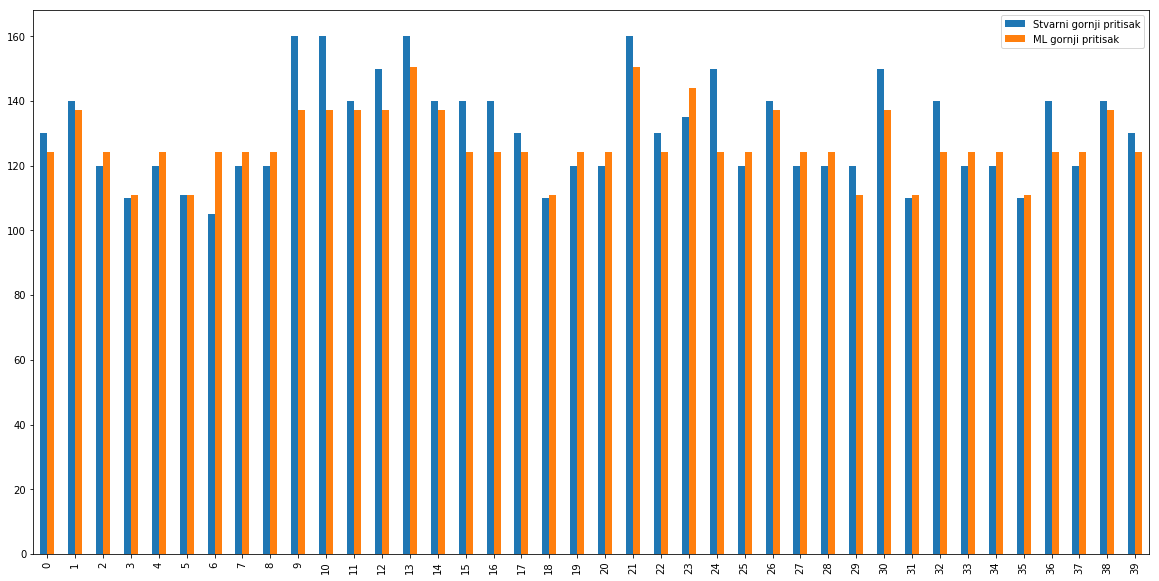

In [35]:
#Grafički prikazujemo tačnost predviđanja za početni deo dataseta

ap_hi1 = rezultati_slr.head(40)
ap_hi1.plot(kind = "bar", figsize = (20, 10))
plt.show()

In [36]:
#Da utvrdimo veličinu greške

#Prosek greške
mean1 = metrics.mean_absolute_error(y_test, y_pred)
print("Mean Absolute error:", mean1)

Mean Absolute error: 7.5468982057942124


In [37]:
#Prosek greške na kvadrat

mse1 = metrics.mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse1)

Mean Squared Error: 105.87729921729378


In [38]:
#Koren proseka greške na kvadrat

rmse1 = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error", rmse1)

Root Mean Squared Error 10.289669538779842


## Multiple Linear Regresion

In [39]:
#Delimo dataset na atribute - X i na lebel - y

X = clean[[ "age", "gender", "height", "weight", "ap_lo", "cholesterol", "gluc", 
            "smoke", "alco", "cardio"]].values
y = clean[["ap_hi"]].values

In [40]:
#Podela dataseta na treninig i test skup

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [41]:
#Kod multiple linearne regresije moramo da nađemo optimalne vrednosti za sve atribute 
#pomoću koeficijena

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [42]:
y_pred2 = regressor.predict(X_test)
y_pred2

array([[120.97182668],
       [137.64063893],
       [129.33142371],
       ...,
       [126.71828928],
       [149.31405477],
       [122.19448719]])

In [43]:
rezultat2 = pd.DataFrame({"Stvarni gornji pritisak": y_test.flatten(), "ML gornji pritisak": y_pred2.flatten()})
rez = rezultat2.head(40)
rez.head()

,Stvarni gornji pritisak,ML gornji pritisak
0,130,120.97
1,140,137.64
2,120,129.33
3,110,108.41
4,120,120.91


In [44]:
rezultat2.describe()

,Stvarni gornji pritisak,ML gornji pritisak
count,12501.00,12501.00
mean,126.48,126.49
std,14.31,10.51
min,90.00,101.34
25%,120.00,120.46
50%,120.00,125.75
75%,140.00,133.73
max,170.00,155.74


In [45]:
#Uzimamo podatak o standardnoj devijaciji za Multiple Linear Regression

vrednost2 = rezultat2["ML gornji pritisak"].std()
vrednost2

10.507916173751195

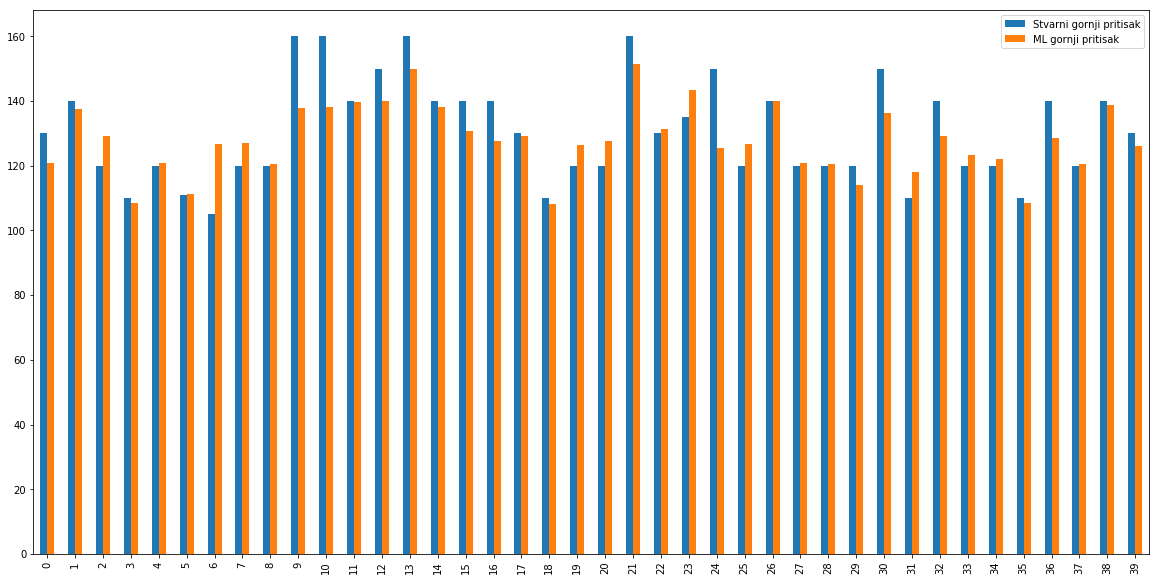

In [46]:
rez.plot(y = ["Stvarni gornji pritisak", "ML gornji pritisak"], kind = "bar", figsize = (20, 10))
plt.show()

In [47]:
#Da utvrdimo veličinu greške
#Prosek greške

mean2 = metrics.mean_absolute_error(y_test, y_pred2)
print("Mean Absolute error:", mean2)

Mean Absolute error: 6.883703189275287


In [48]:
#Prosek greške na kvadrat

mse2 = metrics.mean_squared_error(y_test, y_pred2)
print("Mean Squared Error:", mse2)

Mean Squared Error: 94.50978743888389


In [129]:
#Koren proseka greškw na kvadrat

rmse2 = np.sqrt(metrics.mean_squared_error(y_test, y_pred2))
print("Root Mean Squared Error", rmse2)

Root Mean Squared Error 10.289669538779842
